In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/user_study/evaluation_study/transcription_and_analysis/"

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

In [5]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

In [6]:
def dcg(r, k, method=0,debug=False):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)+1):
        val+= (r[i-1]) / np.log2(i+1)
        if debug:
            print ("i=",i,":",(r[i-1]) ,"/", np.log2(i+1))
            print ((r[i-1]) / np.log2(i+1))
    return val

def ndcg(ground_truth_r,r, k,debug=False):
    return dcg(r, k,debug=debug) / dcg(ground_truth_r,k,debug=debug)

In [7]:
from sklearn import metrics

In [76]:
import copy

In [127]:
def PRF_at_k(ground_truth_r,r, k,debug=False):
    ground_truth_r = np.array(ground_truth_r)
    r = np.array(r)
    #coerce ground truth to binary (i.e. if ranking above k then relevant, if below k then marked as irrelevant)
    binarize_ground_truth_r = np.where(ground_truth_r>3, 0, 1)
    binarize_r = np.where(r>k, 0, 1)
    srt_r = copy.deepcopy(r)
    srt_r = sort(srt_r)[:k]
    binarize_r = []
    for x in r:
        if x in srt_r:
            binarize_r.append(1)
        else : 
            binarize_r.append(0)
    #print (binarize_ground_truth_r,binarize_r)
    #assert len(binarize_r)==len(binarize_ground_truth_r)
    p,r,fscore,_ = metrics.precision_recall_fscore_support(binarize_ground_truth_r,binarize_r,average='binary')
    
    #p = tp/(tp+fp)
    #r = tr/(tr+fn)
    ap = metrics.average_precision_score(binarize_ground_truth_r,binarize_r,average=None)
    return p,r, fscore,ap

In [128]:
p,r,f,ap = PRF_at_k([1,2,3,4,5],[1,1,2,2,1],3)
print (p,r)
# assert (p,r,f==[0,0,0])

0.6666666666666666 0.6666666666666666


In [104]:
ground_truth_ratings = [1,2,3,4,5,6]
example_ratings = [3,2,3,0,1,2]
ideal_ordering = [3,3,3,2,2,2,1,0]
assert np.isclose(dcg(example_ratings,6),6.861,1e-2) #check DCG calculation (Based on Wikipedia example)
assert np.isclose(ndcg(ideal_ordering,[3,2,3,0,1,2],6),0.785,1e-2) #check NDCG calculation (Based on Wikipedia example)
assert np.isclose(ndcg([3,1,2],[3, 1, 2],3),1) #sanity check

In [10]:
p,r,f,ap = PRF_at_k(ground_truth_ratings,example_ratings,1)
assert (p,r,f==[0,0,0])
p,r,f,ap = PRF_at_k(ground_truth_ratings,example_ratings,len(example_ratings))
assert (p,r,f==[1,1,1])

In [11]:
# p_lst = []
# r_lst = []
# for k in range(1,len(example_ratings)+1):
#     p,r,f = PRF_at_k(ground_truth_ratings,example_ratings,k)
#     p_lst.append(p)
#     r_lst.append(r)

# plt.plot(r_lst,p_lst,'o')

In [12]:
# ndcg([3.0, 1.0, 2.0],[3.0, 2.0, 1.0],3,debug=True)

In [13]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    k = len(ground_truth_rank["attribute"])
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        #print (trial)
        ndcg_d.append(trial[0])
        #for k in k_lst:
        ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
#             print trial[1]
        ndcg_data.append(ndcg_d)
#    print ndcg_data
    NDCG_lst = ["NDCG@"+str(k)]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task"]+NDCG_lst)
    #print (ndcg_result)
    return ndcg_result.groupby("Task",as_index=False).mean()

In [14]:
ndcg_result=[["Police"]+list(compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")["NDCG@7"]),
["Autism"]+list(compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")["NDCG@10"])]

In [15]:
import tabulate as T

In [16]:
print (T.tabulate(ndcg_result,headers=['Dataset','system','Cluster','BFS'],tablefmt='latex', floatfmt=".2f"))

\begin{tabular}{lrrr}
\hline
 Dataset   &   system &   Cluster &   BFS \\
\hline
 Police    &     0.32 &      0.28 &  0.37 \\
 Autism    &     0.19 &      0.29 &  0.20 \\
\hline
\end{tabular}


- NDCG@1 is 0 because if the first-ranked attribute is not retreived, then score would be 0.
- This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.
- NDCG should be @10 because all users read through and ranked all 10 dashboards.

In [20]:
import scipy

In [38]:
def normalized_ranking(rank_list):
    nrank = []
    for rank in rank_list:
        normalized_rank = (float(rank)-min(rank_list))/(max(rank_list)-min(rank_list))
#         print normalized_rank
        nrank.append(normalized_rank)
    return nrank

In [53]:
from collections import Counter
from collections import OrderedDict

In [54]:
new_ranking

[2, 2, 5, 4, 1, 3, 1]

In [56]:
d = Counter(new_ranking)
od = OrderedDict(sorted(d.items(), key=lambda t: t[0]))

In [58]:
od

OrderedDict([(1, 2), (2, 2), (3, 1), (4, 1), (5, 1)])

In [70]:
csum=0
k_lst = []
for key, value in od.items():
    csum+= value
    print (csum)
    k_lst.append(csum)
#    csum+=od[kv][1]

2
4
5
6
7


[0.29762761 0.31138172 0.53700434 0.59209095 0.35142862 0.6355758 ]
1
2
4
5
6
k: 1
1.0 0.3333333333333333
k: 2
0.5 0.3333333333333333
k: 4
0.5 0.6666666666666666
k: 5
0.6 1.0
k: 6
0.5 1.0
[6.0, 5.0, 3.0, 2.0, 4.0, 1.0] [2, 3, 1, 3, 5, 4] 0.6739320127787427 -0.27602622373694163 -0.2692820548524554 -0.27602622373694163 -0.2692820548524554
[0.29762761 0.31138172 0.44107372 0.46994519 0.53700434]
1
2
3
4
5
k: 1
1.0 0.3333333333333333
k: 2
1.0 0.6666666666666666
k: 3
1.0 1.0
k: 4
0.75 1.0
k: 5
0.6 1.0
[5.0, 4.0, 3.0, 2.0, 1.0] [5, 4, 3, 2, 1] 1.0 0.9999999999999999 1.0 0.9999999999999999 1.0
[0.31138172 0.59209095 0.35142862 0.6355758  0.38591708]
2
3
4
5
k: 2
1.0 0.6666666666666666
k: 3
0.6666666666666666 0.6666666666666666
k: 4
0.5 0.6666666666666666
k: 5
0.6 1.0
[5.0, 2.0, 4.0, 1.0, 3.0] [2, 1, 3, 1, 4] 0.620010043412533 0.31622776601683794 0.15159185870670672 0.31622776601683794 0.15159185870670672
[0.29762761 0.31138172 0.44107372 0.46994519]
1
2
3
4
k: 1
0.0 0.0
k: 2
0.5 0.33333333333

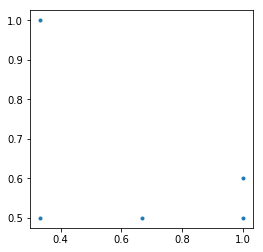

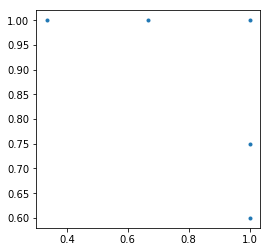

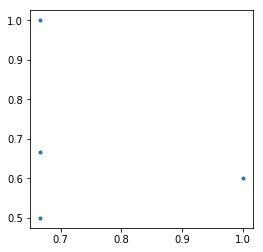

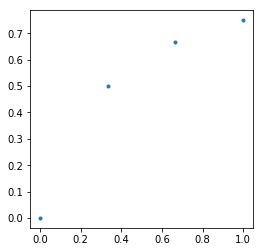

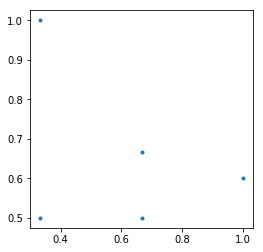

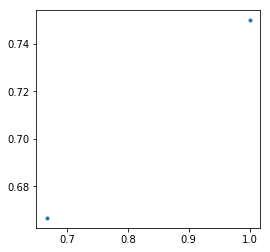

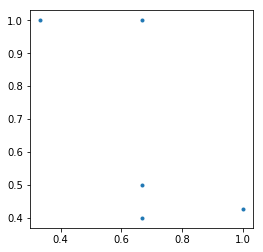

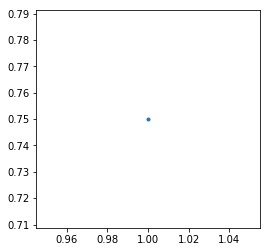

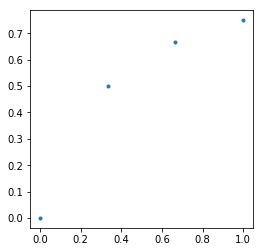

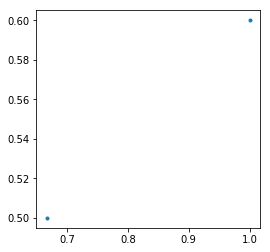

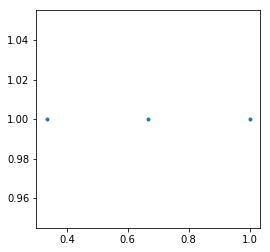

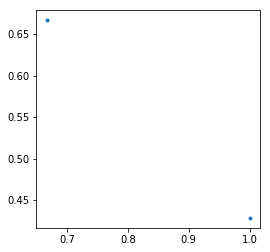

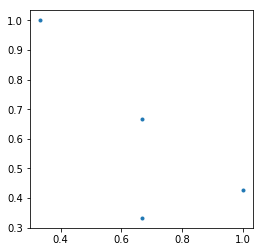

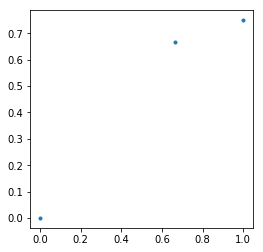

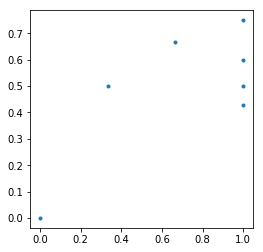

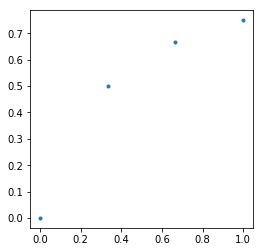

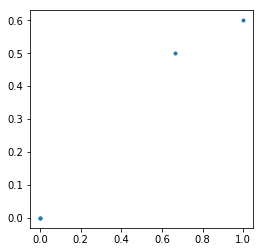

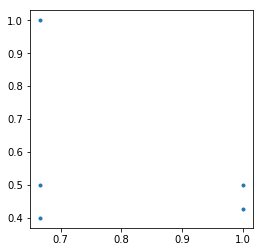

In [129]:
# user_ranking_filename = "Ranking(Police).csv"
# gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
user_ranking_filename = "Ranking(Autism).csv"
gt_ranking_filename = "autism_ground_truth_correlation.csv"
user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
k =3
#print ground_truth_cramerV_rank
if "Police" in user_ranking_filename: 
    task_name = "Task1"
else: 
    task_name = "Task2"
#highest cramer's V corresponds to most correlated, corresponds to rank 1
user_rank = user_rank.merge(user_task).drop("Note",axis=1)
user_rankings=[]
ndcg_data = []
#Putting user rankings into appropriate data structures
for row in user_rank.iterrows():
    ranking = []
    for attr in ground_truth_rank.attribute:
        ranking.append(row[1][attr])
    task = row[1][task_name]
    #Recompute the ground truth rating after throwing away unrated instances
    ranking = np.array(ranking)
    unrated_idxs =  np.where(ranking==0)[0]

    new_ranking = list(np.delete(ranking, unrated_idxs))
    new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),unrated_idxs)
    print (new_CramerV)
    assert len(new_ranking) == len(new_CramerV)
    ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
    ngt = normalized_ranking(ground_truth_cramerV_rank)
    nuser = normalized_ranking(new_ranking)
    tau = scipy.stats.kendalltau(ground_truth_cramerV_rank,new_ranking)[0]
    wtau = scipy.stats.weightedtau(ground_truth_cramerV_rank,new_ranking)[0]
    
    ntau = scipy.stats.kendalltau(ngt,nuser)[0]
    nwtau = scipy.stats.weightedtau(ngt,nuser)[0]
    
    d = Counter(new_ranking)
    od = OrderedDict(sorted(d.items(), key=lambda t: t[0]))
    csum=0
    k_lst = []
    for key, value in od.items():
        csum+= value
        print (csum)
        k_lst.append(csum)
    #Computing ndcg ranking
#         k=4
    ndcg_k = len(new_ranking)
    ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,ndcg_k)
    p_lst = []
    r_lst = [] 
    plt.figure()
    for k in k_lst:
        print ("k:",k)
        p,r,f,ap=PRF_at_k(ground_truth_cramerV_rank,new_ranking,k)
        p_lst.append(p)
        r_lst.append(r)
        print (p,r)
    plt.plot(r_lst,p_lst,'.')
    #print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
    print (ground_truth_cramerV_rank, new_ranking, ndcg_val, tau, wtau,ntau,nwtau)
    ndcg_data.append([task,ndcg_val,p,r,f,ap,tau,wtau,ntau,nwtau,k])
ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG","P","R","F-Score","AP","Tau","WeightedTau","NTau","NWeightedTau","k"])

In [43]:
ndcg_result.groupby("Task").mean()

,NDCG,P,R,F-Score,AP,Tau,WeightedTau,NTau,NWeightedTau,k
Task,,,,,,,,,,
B1,0.765871,0.725000,0.791667,0.754630,0.746263,-0.268686,-0.312766,-0.268686,-0.312766,3.833333
B2,0.550991,0.835317,1.000000,0.909757,0.835317,0.022370,-0.007990,0.022370,-0.007990,5.333333
B3,0.655138,0.772222,0.888889,0.822751,0.781481,0.036994,0.003378,0.036994,0.002815,3.333333


In [30]:
ndcg_result.groupby("Task").mean()

,NDCG,P,R,F-Score,AP,Tau,WeightedTau,k
Task,,,,,,,,
B1,0.765871,0.666667,0.722222,0.690476,0.665476,-0.268686,-0.312766,3
B2,0.550991,0.485317,0.777778,0.590741,0.488228,0.022370,-0.007990,3
B3,0.655138,0.738889,0.888889,0.799603,0.748148,0.036994,0.003378,3


In [32]:
ndcg_result

,Task,NDCG,P,R,F-Score,AP,Tau,WeightedTau,k
0,B2,0.673932,0.500000,0.666667,0.571429,0.500000,-0.276026,-0.269282,3
1,B3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3
2,B1,0.620010,0.500000,0.666667,0.571429,0.533333,0.316228,0.151592,3
3,B3,0.803591,0.666667,0.666667,0.666667,0.694444,0.000000,-0.066667,3
4,B1,0.797437,0.666667,0.666667,0.666667,0.644444,0.000000,-0.087591,3
5,B2,0.408588,0.750000,1.000000,0.857143,0.750000,-0.707107,-0.725600,3
6,B2,0.767698,0.500000,0.666667,0.571429,0.476190,0.450564,0.522682,3
7,B3,0.349781,0.750000,1.000000,0.857143,0.750000,NaN,NaN,3
8,B1,0.772174,0.666667,0.666667,0.666667,0.694444,-0.333333,-0.293333,3
9,B3,0.324702,0.600000,1.000000,0.750000,0.600000,-0.632456,-0.661218,3


In [221]:
# user_ranking_filename = "Ranking(Police).csv"
# gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
def compute_exclude_unranked(user_ranking_filename,gt_ranking_filename,k):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)

    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    ndcg_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Recompute the ground truth rating after throwing away unrated instances
        ranking = np.array(ranking)
        unrated_idxs =  np.where(ranking==0)[0]
        new_ranking = list(np.delete(ranking, unrated_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),unrated_idxs)
        assert len(new_ranking) == len(new_CramerV)
        ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        #Computing ndcg ranking
#         k=4
        ndcg_k = len(new_ranking)
        ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,ndcg_k)
        p,r,f,ap=PRF_at_k(ground_truth_cramerV_rank,new_ranking,k)
        #print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
        ndcg_data.append([task,ndcg_val,p,r,f,ap,k])
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG","P","R","F-Score","AP","k"])
    return ndcg_result

In [223]:
ndcg_result = compute_exclude_unranked("Ranking(Police).csv","ct_police_ground_truth_correlation.csv",3)
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG,P,R,F-Score,AP,k
0,A1,0.800910,0.783333,1.000000,0.869048,0.783333,3
1,A2,0.943029,0.847222,0.888889,0.865079,0.839815,3
2,A3,0.911349,0.805556,0.833333,0.817460,0.816138,3


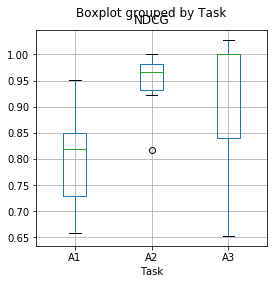

In [224]:
ndcg_result.boxplot("NDCG",by="Task")

In [231]:
ndcg_result = compute_exclude_unranked("Ranking(Autism).csv","autism_ground_truth_correlation.csv",4)

In [232]:
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG,P,R,F-Score,AP,k
0,B1,0.765871,0.850000,0.916667,0.879630,0.844643,4
1,B2,0.550991,0.640476,0.875000,0.731313,0.645040,4
2,B3,0.655138,0.966667,1.000000,0.981481,0.966667,4


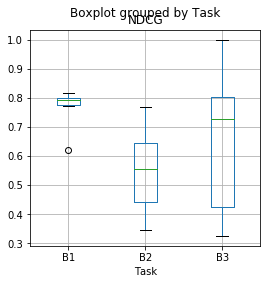

In [234]:
ndcg_result.boxplot("NDCG",by="Task")

# Dashboard attribute coverage

In [239]:
import glob
import json
dashboards = glob.glob("generated_dashboards/*")

In [240]:
dashboard_filters_attributes_only = []
univariate_only = []
for  dashboard_name in dashboards:
    dashboard = json.load(open(dashboard_name))
    dashboard_filters = []
    for id in dashboard.keys():
        if not (dashboard[id][-1]["filter"]=="#"):
            filters = dashboard[id][-1]["filter"].replace("$","=").split("#")[1:-1]
            dashboard_filters.append(filters)
    dashboard_name = dashboard_name.split("/")[1].split("_euclidean")[0]
    for dashbd in dashboard_filters:
        score = 1/len(dashbd)
        if (len(dashbd)==1):
            vis = dashbd[0]
            univariate_only.append([vis[:vis.index("=")],dashboard_name])
        for vis in dashbd:
            dashboard_filters_attributes_only.append([vis[:vis.index("=")],score,dashboard_name])

In [241]:
univariate_df =  pd.DataFrame(univariate_only,columns=["attribute","filename"])
univariate_df["Dataset"] = univariate_df["filename"].apply(lambda x: "autism" in x).apply(lambda x: {True:"Autism",False:"Police"}[x])
univariate_df["Condition"] = univariate_df["filename"].apply(lambda x: {"picking":"Storyboard","kmeans":"KMeans","levelwiseBFS":"BFS"}[x.split("_")[-1]])

In [242]:
univariate_df.groupby(["Dataset","Condition"],as_index=False).count()[["Dataset","Condition","attribute"]].rename(columns={"attribute":"# of Univariate Dashboards in "})

,Dataset,Condition,# of Univariate Dashboards in
0,Autism,BFS,9
1,Autism,KMeans,7
2,Autism,Storyboard,2
3,Police,BFS,9
4,Police,KMeans,3
5,Police,Storyboard,3


In [243]:
df = pd.DataFrame(dashboard_filters_attributes_only,columns=["attribute","%mentioned","filename"])

In [244]:
df["Dataset"] = df["filename"].apply(lambda x: "autism" in x).apply(lambda x: {True:"Autism",False:"Police"}[x])
df["Condition"] = df["filename"].apply(lambda x: {"picking":"Storyboard","kmeans":"KMeans","levelwiseBFS":"BFS"}[x.split("_")[-1]])

In [245]:
# df.groupby(["Dataset","Condition"],as_index=False).agg({"filename": pd.Series.nunique,"attribute":np.sum})

In [246]:
df.groupby(["Dataset","Condition"],as_index=False).count()[["Dataset","Condition","attribute"]].rename(columns={"attribute":"Number of Attributes Covered"})

,Dataset,Condition,Number of Attributes Covered
0,Autism,BFS,9
1,Autism,KMeans,12
2,Autism,Storyboard,19
3,Police,BFS,9
4,Police,KMeans,21
5,Police,Storyboard,16


In [247]:
# df.groupby(["Dataset","Condition","attribute"],as_index=False).sum()

# Exclude if not in univariate

In [248]:
user_ranking_filename = "Ranking(Police).csv"
gt_ranking_filename = "ct_police_ground_truth_correlation.csv"
def compute_ndcg_rankings_exclude_nonunivariate(user_ranking_filename,gt_ranking_filename):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)

    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
        dataset = "Police"
    else: 
        dataset = "Autism"
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    ndcg_data = []
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        #Find the idxs corresponding to attributes that are not shown as univariates in the dashboards to exclude
        attribute_order = list(user_rank.columns)[1:-2]
        condition = {"1":"Storyboard","2":"KMeans","3":"BFS"}[task[1]]
        univariate_coverage= list(univariate_df[(univariate_df["Dataset"]==dataset)&(univariate_df["Condition"]==condition)]["attribute"])
        univariate_coverage = [camelCaseToUnderscore(i) for i in univariate_coverage]
        exclude_idxs= []
        for univar in univariate_coverage:
            exclude_idxs.append(attribute_order.index(univar))
        exclude_idxs = np.array(exclude_idxs)
        #Recompute the ground truth rating after throwing away excluded instances
        ranking = np.array(ranking)
        new_ranking = list(np.delete(ranking, exclude_idxs))
        new_CramerV = np.delete(np.array(ground_truth_rank["cramerV"]),exclude_idxs)
        assert len(new_ranking) == len(new_CramerV)
        k = len(new_ranking)
        ground_truth_cramerV_rank = list(pd.Series(new_CramerV).rank(ascending=False)) 
        #Computing ndcg ranking
        ndcg_d = []
        ndcg_d.append(task)
        ndcg_val=ndcg(ground_truth_cramerV_rank,new_ranking,k)
        #print (ground_truth_cramerV_rank,new_ranking,ndcg_val)
        ndcg_d.append(ndcg_val)
        ndcg_d.append(k)
        ndcg_data.append(ndcg_d)
    #    print ndcg_data
    NDCG_lst = ["NDCG@k"]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task","NDCG@k","k"])
    return ndcg_result

In [249]:
import re

In [250]:
def camelCaseToUnderscore(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [251]:
ndcg_result = compute_ndcg_rankings_exclude_nonunivariate("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,A1,0.421912,4
1,A2,0.442083,4
2,A3,0.621848,4


In [252]:
ndcg_result = compute_ndcg_rankings_exclude_nonunivariate("Ranking(Autism).csv","autism_ground_truth_correlation.csv")
ndcg_result.groupby("Task",as_index=False).mean()

,Task,NDCG@k,k
0,B1,0.199252,8
1,B2,0.184723,4
2,B3,0.000000,5
